In [3]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [4]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,Annotated
import operator
from langchain_core.messages import AnyMessage,SystemMessage,HumanMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage

In [5]:
tool = TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],operator.add]

In [33]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge(START, "llm")
        graph.add_edge("action", "llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        messages = self.model.invoke(messages)
        return {'messages': [messages]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=results))
        print("Back to the Model!")
        return {'messages': results}

In [34]:
prompt="""You are a smart research assistant. Use the search engine to find the information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow-up question, do so.
Please summarize the findings clearly and concisely.
If the information is not available, suggest alternative approaches or related topics to explore.
Always ensure that the information is accurate and relevant to the query.
"""
model = ChatOpenAI(model="gpt-4o")
abot=Agent(model, [tool] , system=prompt)

In [ ]:
#!pip install matplotlib

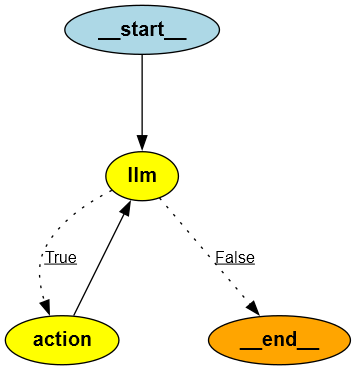

In [35]:
from IPython.display import Image
Image(abot.graph.get_graph().draw_png())

In [40]:
messages=[HumanMessage(content="What is the weather is LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_AJuoWuQPmv0s03cCBPWo3E56', 'type': 'tool_call'}
Back to the Model!


In [41]:
result

{'messages': [HumanMessage(content='What is the weather is LA?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AJuoWuQPmv0s03cCBPWo3E56', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 186, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4fe7e761-5cac-4581-b04b-bf7ce4241c28-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_AJuoWuQPmv0s03cCBPWo3E56', 'type': 'tool_ca